# TESTING HYPERPARAMETERS
# TRANSFORMER. 8 featerow - mag, x, y, depth, dist, distance, plate, days_diff. 
### num_layers=2, d_model=48, num_heads=4

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)

2024-01-26 06:48:58.174751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 06:48:58.174828: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 06:48:58.174857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 06:48:58.191323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 06:48:59.195409: W tensorflow/compiler/

In [2]:
ds_train = tf.data.Dataset.load("../data/ds_train/")
ds_val = tf.data.Dataset.load("../data/ds_val/")
ds_test = tf.data.Dataset.load("../data/ds_test/")

2024-01-26 06:49:00.567941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 06:49:00.644397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 06:49:00.644474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 06:49:00.650737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 06:49:00.650856: I tensorflow/compile

In [3]:
ds_train.cardinality().numpy(), ds_val.cardinality().numpy(), ds_test.cardinality().numpy()

(3294436, 465661, 101326)

In [4]:
BATCH_SIZE = 1024
BLOCK_SIZE = 64

In [5]:
def fix_x_and_y(features, context, labels):
    return features, labels

In [6]:
ds_train = ds_train.map(fix_x_and_y)
ds_val = ds_val.map(fix_x_and_y)
ds_test = ds_test.map(fix_x_and_y)

In [7]:
for x, y in ds_train.batch(BATCH_SIZE).take(1):
    print(x[0].shape)
    print(x[1].shape)
    print(y.shape)

(64, 9)
(64, 9)
(1024, 1)


In [8]:
# ys = []
# for x, y in ds_train.batch(BATCH_SIZE):
#     ys.append(y.numpy())
# ys = np.concatenate(ys)
# np.bincount(tf.cast(ys, tf.int32).numpy().flatten())

In [9]:
#neg, pos = np.bincount(tf.cast(ys, tf.int32).numpy().flatten())
neg, pos = 3094591, 199845
total = neg + pos
total, pos, neg

(3294436, 199845, 3094591)

In [10]:
ds_train = ds_train.batch(BATCH_SIZE).shuffle(2000, seed=SEED, reshuffle_each_iteration=False).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.dense = tf.keras.layers.Dense(d_model // 9 * 6)
        self.embed_dd = tf.keras.layers.Embedding(20, d_model // 9)
        self.embed_plate = tf.keras.layers.Embedding(64, d_model // 9)
        self.embed_magtype = tf.keras.layers.Embedding(20, d_model // 9)
        self.conc = tf.keras.layers.Concatenate()
        self.pos_encoding = tf.keras.layers.Embedding(64, d_model)

    def call(self, x):
        cont, plate, dd, magtype = x[:,:,:-3], x[:,:,-3], x[:,:,-2], x[:,:,-1] 
        x1 = self.dense(cont)
        x2 = self.embed_dd(dd)
        x3 = self.embed_plate(plate)
        x4 = self.embed_magtype(magtype)
        x = self.conc([x1, x2, x3, x4])
        x_pos = self.pos_encoding(tf.range(x1.shape[1]))
        x = x + x_pos
        return x

In [12]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [13]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [14]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [15]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderBlock, self).__init__()

        self.causal_self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.causal_self_attention(x=x)
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [16]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_blocks = [
            DecoderBlock(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

    def call(self, x):
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.dropout(x)
        for block in self.dec_blocks:
            x = block(x)
        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [17]:
@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads,
                dropout_rate=0.1):
        super().__init__()
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=4*d_model,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.decoder(inputs) # (batch_size, target_len, d_model)
        x = x[:, -1, :]
        logits = self.final_layer(x)  # (batch_size, 1, target_vocab_size)
        return logits

In [18]:
model = Transformer(num_layers=2, d_model=180, num_heads=2)

In [19]:
model.build(input_shape=(None, BLOCK_SIZE, 9))
model.count_params()

1057181

In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps
        }

In [21]:
learning_rate = CustomSchedule(180)
model.compile(tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [22]:
import matplotlib.pyplot as plt

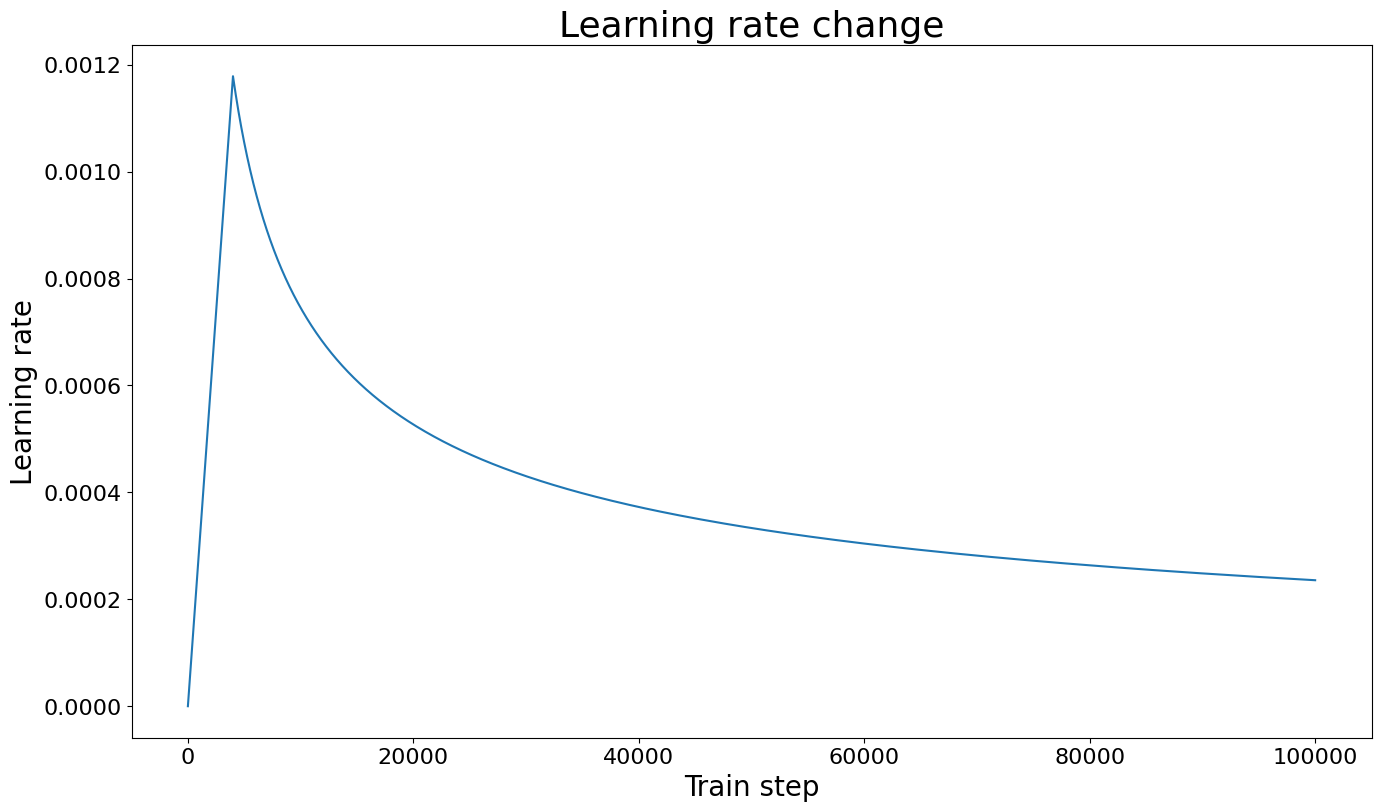

In [23]:
plt.figure(figsize=(16, 9))
plt.plot(learning_rate(tf.range(100_000, dtype=tf.float32)))
plt.title('Learning rate change', fontsize=26)
plt.ylabel('Learning rate', fontsize=20)
plt.xlabel('Train step', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [24]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight, neg, pos, total

({0: 0.5322894043186968, 1: 8.2424779203883}, 3094591, 199845, 3294436)

In [25]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
history = model.fit(ds_train, epochs=30, validation_data=ds_val, class_weight=class_weight) # 4:32min

Epoch 1/30


2024-01-22 19:51:47.807419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 206 of 2000
2024-01-22 19:52:07.849910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 614 of 2000
2024-01-22 19:53:10.255319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 903 of 2000
2024-01-22 19:53:27.870874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1023 of 2000
2024-01-22 19:53:47.941284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1181 of 2000
2024-01-22 19:54:07.834600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take 

3218/3218 [==============================] - 1850s 449ms/step - loss: 0.5070 - accuracy: 0.8007 - recall: 0.7311 - precision: 0.1951 - val_loss: 0.5364 - val_accuracy: 0.8647 - val_recall: 0.4330 - val_precision: 0.2124
Epoch 2/30


2024-01-22 20:22:33.622787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 117 of 2000
2024-01-22 20:22:43.630529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 253 of 2000
2024-01-22 20:22:53.699213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 386 of 2000
2024-01-22 20:23:13.654256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 587 of 2000
2024-01-22 20:23:23.663446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 693 of 2000
2024-01-22 20:23:43.596032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 1795s 496ms/step - loss: 0.4569 - accuracy: 0.8363 - recall: 0.7557 - precision: 0.2355 - val_loss: 0.4855 - val_accuracy: 0.8724 - val_recall: 0.4266 - val_precision: 0.2242
Epoch 3/30


2024-01-22 20:52:28.620869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 89 of 2000
2024-01-22 20:52:48.462898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 277 of 2000
2024-01-22 20:52:58.471866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 358 of 2000
2024-01-22 20:53:18.489541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 594 of 2000
2024-01-22 20:53:38.453696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 880 of 2000
2024-01-22 20:53:48.480543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 1804s 502ms/step - loss: 0.4313 - accuracy: 0.8481 - recall: 0.7581 - precision: 0.2511 - val_loss: 0.4670 - val_accuracy: 0.8308 - val_recall: 0.5773 - val_precision: 0.2010
Epoch 4/30


2024-01-22 21:22:32.977642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 117 of 2000
2024-01-22 21:22:45.191850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 145 of 2000
2024-01-22 21:22:58.541709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 147 of 2000
2024-01-22 21:23:13.004011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 259 of 2000
2024-01-22 21:23:23.076205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 342 of 2000
2024-01-22 21:23:43.036044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 1854s 506ms/step - loss: 0.4143 - accuracy: 0.8418 - recall: 0.7789 - precision: 0.2461 - val_loss: 0.4318 - val_accuracy: 0.8629 - val_recall: 0.4120 - val_precision: 0.2035
Epoch 5/30


2024-01-22 21:53:27.148956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 107 of 2000
2024-01-22 21:53:47.158257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 327 of 2000
2024-01-22 21:54:07.076206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 519 of 2000
2024-01-22 21:54:17.107385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 627 of 2000
2024-01-22 21:54:27.172376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 740 of 2000
2024-01-22 21:54:47.139764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2174s 608ms/step - loss: 0.4036 - accuracy: 0.8339 - recall: 0.8054 - precision: 0.2405 - val_loss: 0.4146 - val_accuracy: 0.8104 - val_recall: 0.5952 - val_precision: 0.1840
Epoch 6/30


2024-01-22 22:29:41.595501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 96 of 2000
2024-01-22 22:30:01.589940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 284 of 2000
2024-01-22 22:30:11.633212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 371 of 2000
2024-01-22 22:30:31.561554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 539 of 2000
2024-01-22 22:30:41.585755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 637 of 2000
2024-01-22 22:31:01.539626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 3682s 1s/step - loss: 0.3955 - accuracy: 0.8337 - recall: 0.8162 - precision: 0.2419 - val_loss: 0.4198 - val_accuracy: 0.8042 - val_recall: 0.6316 - val_precision: 0.1853
Epoch 7/30


2024-01-22 23:31:04.822854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 82 of 2000
2024-01-22 23:31:14.823157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 182 of 2000
2024-01-22 23:31:24.867443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 280 of 2000
2024-01-22 23:31:44.857826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 441 of 2000
2024-01-22 23:32:04.822055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 603 of 2000
2024-01-22 23:32:14.887369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 5556s 2s/step - loss: 0.3866 - accuracy: 0.8331 - recall: 0.8275 - precision: 0.2429 - val_loss: 0.4355 - val_accuracy: 0.7742 - val_recall: 0.6260 - val_precision: 0.1614
Epoch 8/30


2024-01-23 01:03:41.682656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 98 of 2000
2024-01-23 01:04:01.601608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 293 of 2000
2024-01-23 01:04:11.604714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 390 of 2000
2024-01-23 01:04:21.617331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 482 of 2000
2024-01-23 01:04:31.741740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 561 of 2000
2024-01-23 01:04:51.645936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 1869s 513ms/step - loss: 0.3797 - accuracy: 0.8364 - recall: 0.8306 - precision: 0.2474 - val_loss: 0.4227 - val_accuracy: 0.7989 - val_recall: 0.6287 - val_precision: 0.1803
Epoch 9/30


2024-01-23 01:34:50.394406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 113 of 2000
2024-01-23 01:35:00.442327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 232 of 2000
2024-01-23 01:35:10.490705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 320 of 2000
2024-01-23 01:35:30.487846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 470 of 2000
2024-01-23 01:35:50.384875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 628 of 2000
2024-01-23 01:36:10.401786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 4024s 1s/step - loss: 0.3735 - accuracy: 0.8410 - recall: 0.8316 - precision: 0.2532 - val_loss: 0.4381 - val_accuracy: 0.7848 - val_recall: 0.6428 - val_precision: 0.1718
Epoch 10/30


2024-01-23 02:41:54.849931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 91 of 2000
2024-01-23 02:42:14.893956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 283 of 2000
2024-01-23 02:42:34.755878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 444 of 2000
2024-01-23 02:42:44.816870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 523 of 2000
2024-01-23 02:43:04.794263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 693 of 2000
2024-01-23 02:43:14.906661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 4228s 1s/step - loss: 0.3680 - accuracy: 0.8422 - recall: 0.8363 - precision: 0.2555 - val_loss: 0.4331 - val_accuracy: 0.7908 - val_recall: 0.6479 - val_precision: 0.1773
Epoch 11/30


2024-01-23 03:52:22.936498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 96 of 2000
2024-01-23 03:52:32.934481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 191 of 2000
2024-01-23 03:52:53.010090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 352 of 2000
2024-01-23 03:53:12.915629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 502 of 2000
2024-01-23 03:53:32.884780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 670 of 2000
2024-01-23 03:53:52.971543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 4241s 1s/step - loss: 0.3620 - accuracy: 0.8471 - recall: 0.8385 - precision: 0.2622 - val_loss: 0.4003 - val_accuracy: 0.8076 - val_recall: 0.6331 - val_precision: 0.1886
Epoch 12/30


2024-01-23 05:03:04.008515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 104 of 2000
2024-01-23 05:03:14.082905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 205 of 2000
2024-01-23 05:03:34.079867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 361 of 2000
2024-01-23 05:03:54.026471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 504 of 2000
2024-01-23 05:04:04.068244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 591 of 2000
2024-01-23 05:04:14.105340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 4263s 1s/step - loss: 0.3578 - accuracy: 0.8479 - recall: 0.8419 - precision: 0.2639 - val_loss: 0.4099 - val_accuracy: 0.8075 - val_recall: 0.6478 - val_precision: 0.1912
Epoch 13/30


2024-01-23 06:14:07.367466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 102 of 2000
2024-01-23 06:14:17.504960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 182 of 2000
2024-01-23 06:14:37.357276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 346 of 2000
2024-01-23 06:14:47.399725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 420 of 2000
2024-01-23 06:15:07.396249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 598 of 2000
2024-01-23 06:15:27.438882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 4238s 1s/step - loss: 0.3526 - accuracy: 0.8508 - recall: 0.8441 - precision: 0.2681 - val_loss: 0.4065 - val_accuracy: 0.8184 - val_recall: 0.6266 - val_precision: 0.1977
Epoch 14/30


2024-01-23 07:24:45.299496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 103 of 2000
2024-01-23 07:24:55.325910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 208 of 2000
2024-01-23 07:25:15.359859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 357 of 2000
2024-01-23 07:25:35.390335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 524 of 2000
2024-01-23 07:25:55.235114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 685 of 2000
2024-01-23 07:26:05.313522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 4250s 1s/step - loss: 0.3479 - accuracy: 0.8521 - recall: 0.8473 - precision: 0.2705 - val_loss: 0.3865 - val_accuracy: 0.8332 - val_recall: 0.6480 - val_precision: 0.2179
Epoch 15/30


2024-01-23 08:35:35.745424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 104 of 2000
2024-01-23 08:35:45.794270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 190 of 2000
2024-01-23 08:36:05.691399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 344 of 2000
2024-01-23 08:36:15.729488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 433 of 2000
2024-01-23 08:36:35.759447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 578 of 2000
2024-01-23 08:36:55.776499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 4268s 1s/step - loss: 0.3424 - accuracy: 0.8542 - recall: 0.8499 - precision: 0.2739 - val_loss: 0.4092 - val_accuracy: 0.8223 - val_recall: 0.7203 - val_precision: 0.2186
Epoch 16/30


2024-01-23 09:46:44.130676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 78 of 2000
2024-01-23 09:46:54.160084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 159 of 2000
2024-01-23 09:47:14.116656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 318 of 2000
2024-01-23 09:47:24.135095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 402 of 2000
2024-01-23 09:47:44.134087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 575 of 2000
2024-01-23 09:47:54.152734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 4271s 1s/step - loss: 0.3372 - accuracy: 0.8558 - recall: 0.8539 - precision: 0.2768 - val_loss: 0.3823 - val_accuracy: 0.8229 - val_recall: 0.7219 - val_precision: 0.2196
Epoch 17/30


2024-01-23 10:57:55.356583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 100 of 2000
2024-01-23 10:58:15.425927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 252 of 2000
2024-01-23 10:58:35.307276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 409 of 2000
2024-01-23 10:58:45.401254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 482 of 2000
2024-01-23 10:59:05.334114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 626 of 2000
2024-01-23 10:59:15.381458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 4285s 1s/step - loss: 0.3336 - accuracy: 0.8571 - recall: 0.8557 - precision: 0.2789 - val_loss: 0.3761 - val_accuracy: 0.8257 - val_recall: 0.7015 - val_precision: 0.2191
Epoch 18/30


2024-01-23 12:09:20.679175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 89 of 2000
2024-01-23 12:09:30.674145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 176 of 2000
2024-01-23 12:09:50.665715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 304 of 2000
2024-01-23 12:10:00.816409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 372 of 2000
2024-01-23 12:10:20.684699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 525 of 2000
2024-01-23 12:10:30.755349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 4260s 1s/step - loss: 0.3293 - accuracy: 0.8587 - recall: 0.8585 - precision: 0.2818 - val_loss: 0.4005 - val_accuracy: 0.8168 - val_recall: 0.7244 - val_precision: 0.2137
Epoch 19/30


2024-01-23 13:20:20.883365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 76 of 2000
2024-01-23 13:20:40.796071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 217 of 2000
2024-01-23 13:20:50.822287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 297 of 2000
2024-01-23 13:21:00.826492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 376 of 2000
2024-01-23 13:21:10.890281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 466 of 2000
2024-01-23 13:21:30.781452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 4256s 1s/step - loss: 0.3250 - accuracy: 0.8602 - recall: 0.8605 - precision: 0.2844 - val_loss: 0.3916 - val_accuracy: 0.8237 - val_recall: 0.6821 - val_precision: 0.2135
Epoch 20/30


2024-01-23 14:31:17.118170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 90 of 2000
2024-01-23 14:31:27.141962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 153 of 2000
2024-01-23 14:31:47.132837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 309 of 2000
2024-01-23 14:31:57.325893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 412 of 2000
2024-01-23 14:32:17.143316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 552 of 2000
2024-01-23 14:32:27.164128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 3100s 881ms/step - loss: 0.3220 - accuracy: 0.8609 - recall: 0.8619 - precision: 0.2856 - val_loss: 0.4086 - val_accuracy: 0.8239 - val_recall: 0.6757 - val_precision: 0.2125
Epoch 21/30


2024-01-23 15:22:57.932804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 77 of 2000
2024-01-23 15:23:17.989849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 248 of 2000
2024-01-23 15:23:37.875795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 378 of 2000
2024-01-23 15:23:47.952666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 461 of 2000
2024-01-23 15:24:07.933120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 594 of 2000
2024-01-23 15:24:27.896285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2307s 623ms/step - loss: 0.3180 - accuracy: 0.8634 - recall: 0.8630 - precision: 0.2898 - val_loss: 0.4039 - val_accuracy: 0.8279 - val_recall: 0.6618 - val_precision: 0.2144
Epoch 22/30


2024-01-23 16:01:26.265007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 91 of 2000
2024-01-23 16:01:46.288131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 262 of 2000
2024-01-23 16:01:56.301451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 332 of 2000
2024-01-23 16:02:16.358422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 466 of 2000
2024-01-23 16:02:36.253008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 600 of 2000
2024-01-23 16:02:46.476841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2249s 612ms/step - loss: 0.3151 - accuracy: 0.8640 - recall: 0.8653 - precision: 0.2910 - val_loss: 0.4033 - val_accuracy: 0.8297 - val_recall: 0.6508 - val_precision: 0.2144
Epoch 23/30


2024-01-23 16:38:56.679158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 77 of 2000
2024-01-23 16:39:16.692645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 233 of 2000
2024-01-23 16:39:26.696052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 330 of 2000
2024-01-23 16:39:46.677858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 495 of 2000
2024-01-23 16:39:56.697660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 572 of 2000
2024-01-23 16:40:06.739773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2451s 682ms/step - loss: 0.3123 - accuracy: 0.8653 - recall: 0.8666 - precision: 0.2934 - val_loss: 0.4028 - val_accuracy: 0.8297 - val_recall: 0.6499 - val_precision: 0.2142
Epoch 24/30


2024-01-23 17:19:48.721950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 86 of 2000
2024-01-23 17:20:08.651859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 250 of 2000
2024-01-23 17:20:18.660761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 315 of 2000
2024-01-23 17:20:28.698934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 380 of 2000
2024-01-23 17:20:38.750465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 453 of 2000
2024-01-23 17:20:58.791711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2442s 664ms/step - loss: 0.3101 - accuracy: 0.8664 - recall: 0.8680 - precision: 0.2954 - val_loss: 0.4132 - val_accuracy: 0.8372 - val_recall: 0.6124 - val_precision: 0.2157
Epoch 25/30


2024-01-23 18:00:31.113026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 107 of 2000
2024-01-23 18:00:41.203027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 198 of 2000
2024-01-23 18:01:01.123848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 331 of 2000
2024-01-23 18:01:11.183927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 421 of 2000
2024-01-23 18:01:31.079255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 562 of 2000
2024-01-23 18:01:41.132996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2332s 644ms/step - loss: 0.3068 - accuracy: 0.8680 - recall: 0.8700 - precision: 0.2983 - val_loss: 0.4352 - val_accuracy: 0.8308 - val_recall: 0.6393 - val_precision: 0.2135
Epoch 26/30


2024-01-23 18:39:23.745148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 87 of 2000
2024-01-23 18:39:33.750251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 158 of 2000
2024-01-23 18:39:53.790389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 318 of 2000
2024-01-23 18:40:13.821591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 463 of 2000
2024-01-23 18:40:33.810484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 611 of 2000
2024-01-23 18:40:53.785230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2334s 639ms/step - loss: 0.3041 - accuracy: 0.8676 - recall: 0.8719 - precision: 0.2979 - val_loss: 0.4270 - val_accuracy: 0.8276 - val_recall: 0.6282 - val_precision: 0.2077
Epoch 27/30


2024-01-23 19:18:18.239686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 92 of 2000
2024-01-23 19:18:28.335064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 179 of 2000
2024-01-23 19:18:48.232409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 328 of 2000
2024-01-23 19:18:58.232903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 414 of 2000
2024-01-23 19:19:18.322142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 572 of 2000
2024-01-23 19:19:38.250832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2231s 607ms/step - loss: 0.3012 - accuracy: 0.8699 - recall: 0.8726 - precision: 0.3019 - val_loss: 0.4318 - val_accuracy: 0.8343 - val_recall: 0.5973 - val_precision: 0.2092
Epoch 28/30


2024-01-23 19:55:29.812303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 71 of 2000
2024-01-23 19:55:39.898349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 138 of 2000
2024-01-23 19:55:59.907893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 284 of 2000
2024-01-23 19:56:19.846965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 430 of 2000
2024-01-23 19:56:29.862127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 503 of 2000
2024-01-23 19:56:49.832682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2334s 641ms/step - loss: 0.2995 - accuracy: 0.8705 - recall: 0.8740 - precision: 0.3031 - val_loss: 0.4430 - val_accuracy: 0.8320 - val_recall: 0.5818 - val_precision: 0.2033
Epoch 29/30


2024-01-23 20:34:24.899716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 101 of 2000
2024-01-23 20:34:34.985875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 177 of 2000
2024-01-23 20:34:54.972656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 319 of 2000
2024-01-23 20:35:04.994946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 387 of 2000
2024-01-23 20:35:25.007842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 526 of 2000
2024-01-23 20:35:44.891842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2248s 617ms/step - loss: 0.2970 - accuracy: 0.8714 - recall: 0.8751 - precision: 0.3049 - val_loss: 0.4428 - val_accuracy: 0.8393 - val_recall: 0.5939 - val_precision: 0.2145
Epoch 30/30


2024-01-23 21:11:53.462444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 114 of 2000
2024-01-23 21:12:03.485656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 191 of 2000
2024-01-23 21:12:13.550320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 285 of 2000
2024-01-23 21:12:33.450134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 444 of 2000
2024-01-23 21:12:43.469318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 534 of 2000
2024-01-23 21:13:03.559556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2152s 594ms/step - loss: 0.2950 - accuracy: 0.8724 - recall: 0.8768 - precision: 0.3069 - val_loss: 0.4464 - val_accuracy: 0.8429 - val_recall: 0.5953 - val_precision: 0.2193


In [26]:
model.evaluate(ds_test)

99/99 [==============================] - 28s 279ms/step - loss: 0.3382 - accuracy: 0.8715 - recall: 0.7548 - precision: 0.1216


[0.33817586302757263,
 0.8715334534645081,
 0.7548161149024963,
 0.1215711161494255]

In [22]:
model = tf.keras.models.load_model(f"../models/model_v4_5_cw.keras", compile=False)

In [23]:
model.compile(tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [24]:
model.evaluate(ds_test)

2024-01-26 06:49:26.044726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904


99/99 [==============================] - 16s 108ms/step - loss: 0.3382 - accuracy: 0.8715 - recall: 0.7548 - precision: 0.1216


[0.33817586302757263,
 0.8715334534645081,
 0.7548161149024963,
 0.1215711161494255]

In [27]:
model.save("../models/model_v4_5_cw.keras")

In [28]:
# save history
history = pd.DataFrame.from_dict(history.history)
history.to_csv("../models/history_model_v4_5_cw.csv", index=False)